In [ ]:
from bayes_opt import BayesianOptimization

import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import cv2
from PIL import Image
from tensorflow import keras
from glob import glob
from sklearn.model_selection import train_test_split

# Image Preparation

In [3]:
cv2.imread("cnn_aggregated/335.bmp").shape

(600, 800, 3)

In [5]:

im = Image.open("test_image.bmp")
im.show()
cropped = im.crop((1,1,400,300))
cropped_2 = im.crop((401,1,800,300))
cropped.show()
cropped_2.show()

FileNotFoundError: [Errno 2] No such file or directory: 'test_image.bmp'

In [7]:
def cropImage(image_name, save_1, save_2):
    
    im = Image.open(image_name)
    cropped_1 = im.crop((1,1,400,300))
    cropped_2 = im.crop((401,1,800,300))
    cropped_1.save(save_1)
    cropped_2.save(save_2)
    
    return


In [8]:
def crop_folder_images(directory):
    
    count = 1
    
    for file in os.listdir(directory):
        if file != '.DS_Store':
            cropImage(directory + "/" + file, directory + "_cropped/" + str(count) + ".bmp", directory + "_cropped/" + str(count+1) + ".bmp")
            count += 2
        
    return

In [62]:
from PIL import ImageFile 
ImageFile.LOAD_TRUNCATED_IMAGES = True

crop_folder_images("cnn_aggregated")
crop_folder_images("cnn_coiled")
crop_folder_images("cnn_disconnected")
crop_folder_images("cnn_straight")

# Image Processing

In [2]:
cv2.imread("cnn_aggregated_cropped/3.bmp").shape

(299, 399, 3)

In [3]:
dic = {"disconnected":0, "straight":1, "coiled":2, "aggregated":3}
X = []
Y = []
for i in os.listdir("cnn_disconnected"):
    if i != '.DS_Store':
        image = Image.open("cnn_disconnected/"+i).convert("L")
        image = image.resize((128,128))
        image = np.array(image)
        X.append(image)
        Y.append(0)

for i in os.listdir("cnn_straight"):
    if i != '.DS_Store':
        image = Image.open("cnn_straight/"+i).convert("L")
        image = image.resize((128,128))
        image = np.array(image)
        X.append(image)
        Y.append(1)
        
for i in os.listdir("cnn_coiled"):
    if i != '.DS_Store':
        image = Image.open("cnn_coiled/"+i).convert("L")
        image = image.resize((128,128))
        image = np.array(image)
        X.append(image)
        Y.append(2)
        
for i in os.listdir("cnn_aggregated"):
    if i != '.DS_Store':
        image = Image.open("cnn_aggregated/"+i).convert("L")
        image = image.resize((128,128))
        image = np.array(image)
        X.append(image)
        Y.append(3)

In [4]:
X = np.array(X)
Y = np.array(Y)

In [5]:
train_images, test_images, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, shuffle=True,
                                                                       random_state=44)

train_labels = train_labels[..., tf.newaxis]
test_labels = test_labels[..., tf.newaxis]

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((1664, 128, 128), (1664, 1), (417, 128, 128), (417, 1))

In [6]:
unique, counts = np.unique(np.reshape(train_labels, (1664,)), axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 403, 1: 386, 2: 473, 3: 402}

In [7]:
unique, counts = np.unique(np.reshape(test_labels, (417,)), axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 101, 1: 103, 2: 125, 3: 88}

In [8]:
N_TRAIN = train_images.shape[0]
N_TEST = test_images.shape[0]

In [9]:
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1)

In [10]:
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

In [11]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(1664, 128, 128, 1) (1664, 4)
(417, 128, 128, 1) (417, 4)


In [12]:
N_BATCH = 50
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=1664).batch(N_BATCH).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(N_BATCH)
test_dataset

2022-05-14 14:45:42.607981: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-14 14:45:42.608397: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


<BatchDataset shapes: ((None, 128, 128, 1), (None, 4)), types: (tf.float32, tf.float32)>

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# checkpoint_cb = ModelCheckpoint("saved_model.h5", save_best_only=True)

patience=10
early_stopping_cb = EarlyStopping(patience=patience, restore_best_weights=True, monitor='val_loss')

In [14]:
# callback
patience=10
early_stopping_cb = EarlyStopping(patience=patience, restore_best_weights=True, monitor='val_loss')

# sequential model
cnn_model = keras.models.Sequential()

# input and convolutional layer
cnn_model.add(keras.layers.Conv2D(32, 7, activation='relu', padding='same',
                                  input_shape=[128, 128, 1]))
# pooling layer
cnn_model.add(keras.layers.MaxPooling2D(2))

# convolutional layers and pooling layer

cnn_model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.MaxPooling2D(2))

# convolutional layers and pooling layer

cnn_model.add(keras.layers.Conv2D(128, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.MaxPooling2D(2))

# flatten layer
cnn_model.add(keras.layers.Flatten())

# dense layers
cnn_model.add(keras.layers.Dense(256, activation='relu'))
cnn_model.add(keras.layers.Dropout(0.4))

# output layer
cnn_model.add(keras.layers.Dense(4, activation='softmax'))

# model complie
cnn_model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

In [15]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      1600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0

In [16]:
steps_per_epoch = N_TRAIN//N_BATCH
validation_steps = N_TEST//N_BATCH
print(steps_per_epoch, validation_steps)

33 8


In [ ]:
istrue = os.path.exists("cnn_model.h2")

if not istrue:
    history = cnn_model.fit(train_dataset, 
                        epochs=50, steps_per_epoch=steps_per_epoch, callbacks=[early_stopping_cb], 
                        validation_data=test_dataset, validation_steps=validation_steps)
    cnn_model.save('cnn_model.h2')
    print("model is saved")
else:
    cnn_model = keras.models.load_model('cnn_model.h2')
    print("model is loaded")

In [36]:
cnn_model.evaluate(test_dataset)

9/9 [==============================] - 2s 210ms/step - loss: 0.0039 - accuracy: 0.9976


[0.003941419398567329, 0.9976019]

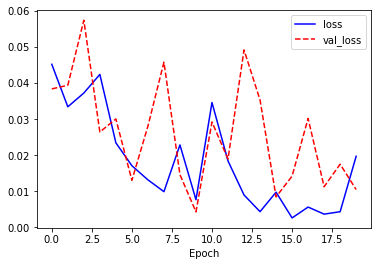

In [37]:
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_onehot = cnn_model.predict(test_images)
y_pred = y_pred_onehot.argmax(axis=1)
y_actual = test_labels.argmax(axis=1)
cm_cnn = confusion_matrix(y_actual, y_pred)
cm_cnn

array([[101,   0,   0,   0],
       [  0, 102,   0,   1],
       [  0,   0, 125,   0],
       [  0,   0,   0,  88]])

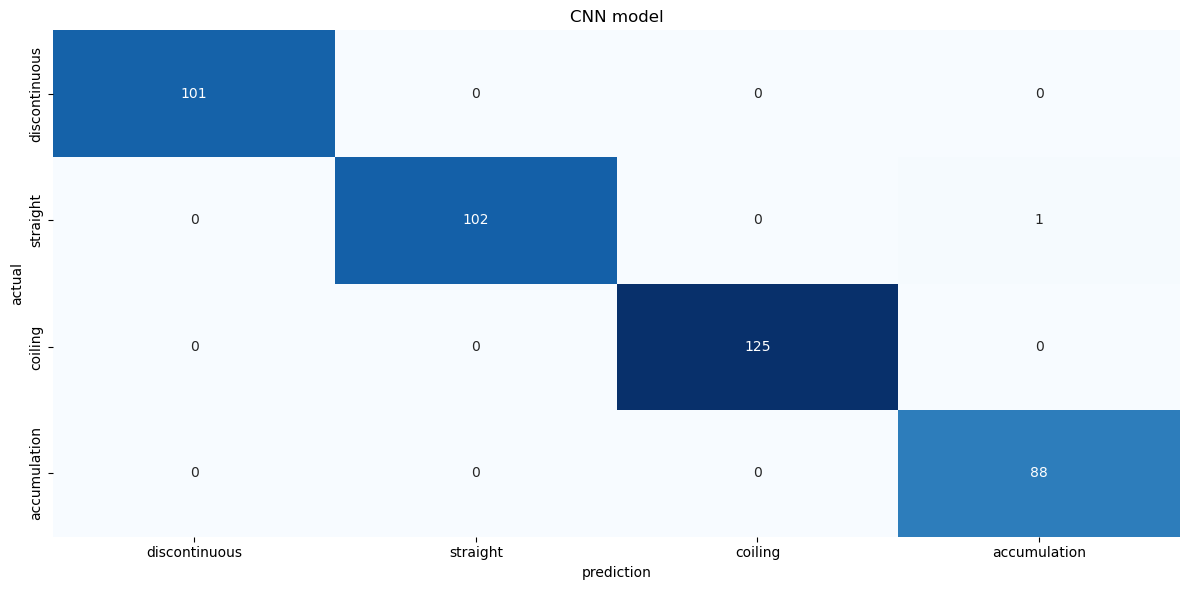

In [40]:
import seaborn as sns
plt.figure(figsize=(12,6), dpi=100)
class_names = ["discontinuous", "straight", "coiling", "accumulation"]
sns.heatmap(cm_cnn, annot=True, fmt='.0f',
            cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=False)
plt.title("CNN model")
plt.xlabel("prediction")
plt.ylabel("actual")
plt.tight_layout()
plt.show()

# Printing Score

In [7]:
folderStringPrinted = "/Users/jonghyun/Desktop/graphene oxide ink/bayesian_opt/bayes_opt_3/bayesian_opt__45-1.bmp"
grayScalePrintedImage = cv2.imread(folderStringPrinted, cv2.IMREAD_GRAYSCALE)
ret, printedImage = cv2.threshold(grayScalePrintedImage, 100, 255, cv2.THRESH_BINARY)

folderStringPrinted_2 = "/Users/jonghyun/Desktop/graphene oxide ink/bayesian_opt/bayes_opt_3/bayesian_opt__45-2.bmp"
grayScalePrintedImage_2 = cv2.imread(folderStringPrinted_2, cv2.IMREAD_GRAYSCALE)
ret_2, printedImage_2 = cv2.threshold(grayScalePrintedImage_2, 100, 255, cv2.THRESH_BINARY)

def LayerImageScore(image):
    h, w = image.shape  
    result = []
    
    for i in range(w):
      score = 0
      for j in range(h):
          if image[j][i] == 0:
            score += 1
          
      if score != 0:
        result.append(score)  
    return result

result_array = LayerImageScore(printedImage)
var = np.var(result_array)
std = np.std(result_array)
m = np.mean(result_array)

result_array_2 = LayerImageScore(printedImage_2)
var_2 = np.var(result_array_2)
std_2 = np.std(result_array_2)
m_2 = np.mean(result_array_2)

#print(grayScalePrintedImage.shape)

std_avg = (std + std_2) / 2
m_avg = (m + m_2) / 2
print("mean = ", m_avg)
print("std = ", std_avg)

#cv2.imshow("printedImage", printedImage)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

mean =  63.23161856963613
std =  18.359490130588224


# Bayesian Optimization

In [7]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

from bayes_opt.util import load_logs

def black_box_function(velocity, pressure_over_velocity, height):
    print("V : ", round(velocity, 2))
    print("P : ", round(pressure_over_velocity * velocity, 1))
    print("H : ", round(height, 2))
    #experiment and input the print-score here
    return float(input("enter printing score : "))

pbounds = {'velocity': (10, 20), 'pressure_over_velocity': (1, 20), 'height': (0.1, 1)}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

#load_logs(optimizer, logs=["/Users/jonghyun/Desktop/logs/2_19.json"])

#logger = JSONLogger(path="/Users/jonghyun/Desktop/logs/2_18.json")
#optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

#optimizer.set_bounds(new_bounds={'velocity': (10, 20), 'pressure_over_velocity': (2, 20), 'height': (0.1, 1)})

optimizer.maximize(
    init_points=2,
    n_iter=2,
)

|   iter    |  target   |  height   | pressu... | velocity  |
-------------------------------------------------------------
V :  10.0
P :  146.9
H :  0.48
enter printing score : 25
|  1        |  25.0     |  0.4753   |  14.69    |  10.0     |
V :  10.92
P :  41.4
H :  0.37
enter printing score : 34
|  2        |  34.0     |  0.3721   |  3.788    |  10.92    |
V :  10.96
P :  42.1
H :  0.55
enter printing score : 46
|  3        |  46.0     |  0.5546   |  3.845    |  10.96    |
V :  11.75
P :  187.5
H :  0.58
enter printing score : 32
|  4        |  32.0     |  0.5791   |  15.96    |  11.75    |


In [8]:
optimizer.set_bounds(new_bounds={'velocity': (10, 20), 'pressure_over_velocity': (2, 20), 'height': (0.1, 1)})
optimizer.maximize(
    init_points=0,
    n_iter=2,
)

|   iter    |  target   |  height   | pressu... | velocity  |
-------------------------------------------------------------
V :  17.47
P :  117.0
H :  0.64
enter printing score : 56
|  5        |  56.0     |  0.6363   |  6.698    |  17.47    |
V :  19.47
P :  93.5
H :  0.3
enter printing score : 43
|  6        |  43.0     |  0.3048   |  4.801    |  19.47    |
